# OSRS hiscores example plots

This notebook reads in example hiscores data and produces plots similar to those produced by the OSRS_hiscores.py script, the purpose being to give a quick example of the type of plots produced.

The plots produced are saved and already available in the `examples/` directory.

---

### Imports, styles and jupyter notebook requirements

In [18]:
import pandas as pd
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches
import sys

sys.path.append('../')
from player.player import Player
import plotting


%matplotlib inline
init_notebook_mode(connected=True)
plt.style.use('ggplot')

---

### Read in example data

In [19]:
player = Player()
player.name = 'example-player'

In [20]:
player.get_player_stats_from_csv()

,Date,Skill,Rank,Level,XP
0,2022-04-14 16:30:00,Overall,53398,2183,262059444
1,2022-04-14 16:30:00,Attack,224348,99,13071871
2,2022-04-14 16:30:00,Defence,280705,94,8146484
3,2022-04-14 16:30:00,Strength,158099,99,15203744
4,2022-04-14 16:30:00,Hitpoints,105583,99,26615385
...,...,...,...,...,...
370,2022-04-18 16:31:00,Vet'ion,16163,100,100
371,2022-04-18 16:31:00,Vorkath,63130,800,800
372,2022-04-18 16:31:00,Wintertodt,261896,253,253
373,2022-04-18 16:31:00,Zalcano,43438,160,160


---

### Split dataframe into "skills" and "kill count" and create "total kill count" dataframe

In [21]:
player.extract_skills()
player.extract_killcount_and_total()

In [22]:
print(player.skills)

                   Date         Skill   Rank  Level         XP
0   2022-04-14 16:30:00       Overall  53398   2183  262059444
75  2022-04-15 16:31:00       Overall  53398   2186  262059444
150 2022-04-16 16:31:00       Overall  53398   2189  266080890
225 2022-04-17 16:31:00       Overall  53398   2189  266820641
300 2022-04-18 16:31:00       Overall  53398   2195  270506641
..                  ...           ...    ...    ...        ...
23  2022-04-14 16:30:00  Construction  56359     97   11695382
98  2022-04-15 16:31:00  Construction  56359     97   11695382
173 2022-04-16 16:31:00  Construction  56359     97   11695382
248 2022-04-17 16:31:00  Construction  56359     97   11695382
323 2022-04-18 16:31:00  Construction  56359     97   11695382

[120 rows x 5 columns]


In [23]:
print(player.killcount)

                   Date                     Boss    Rank  Kill count
24  2022-04-14 16:30:00       Clue Scrolls (all)  123541         270
25  2022-04-14 16:30:00  Clue Scrolls (beginner)  345806           5
26  2022-04-14 16:30:00      Clue Scrolls (easy)   79388          44
27  2022-04-14 16:30:00    Clue Scrolls (medium)  138191          65
28  2022-04-14 16:30:00      Clue Scrolls (hard)  196614          76
..                  ...                      ...     ...         ...
370 2022-04-18 16:31:00                  Vet'ion   16163         100
371 2022-04-18 16:31:00                  Vorkath   63130         800
372 2022-04-18 16:31:00               Wintertodt  261896         253
373 2022-04-18 16:31:00                  Zalcano   43438         160
374 2022-04-18 16:31:00                   Zulrah  155944         400

[255 rows x 4 columns]


In [24]:
print(player.total_killcount)

                 Date  Kill count
0 2022-04-14 16:30:00       12576
1 2022-04-15 16:31:00       12772
2 2022-04-16 16:31:00       12908
3 2022-04-17 16:31:00       13010
4 2022-04-18 16:31:00       13296


---

### Create interactive plots of overall level/XP and total boss kill count

In [25]:
plotting.summary.create_summary_plots(player)  # File saved manually as plotly_overall_stats.png

---

### Plot each skill on figure in facetgrid

C:\Users\emily\Documents\Tom\Coding\OSRS_hiscores\example_plots\..\plotting\grid_plots.py:26: UserWarning:

FixedFormatter should only be used together with FixedLocator



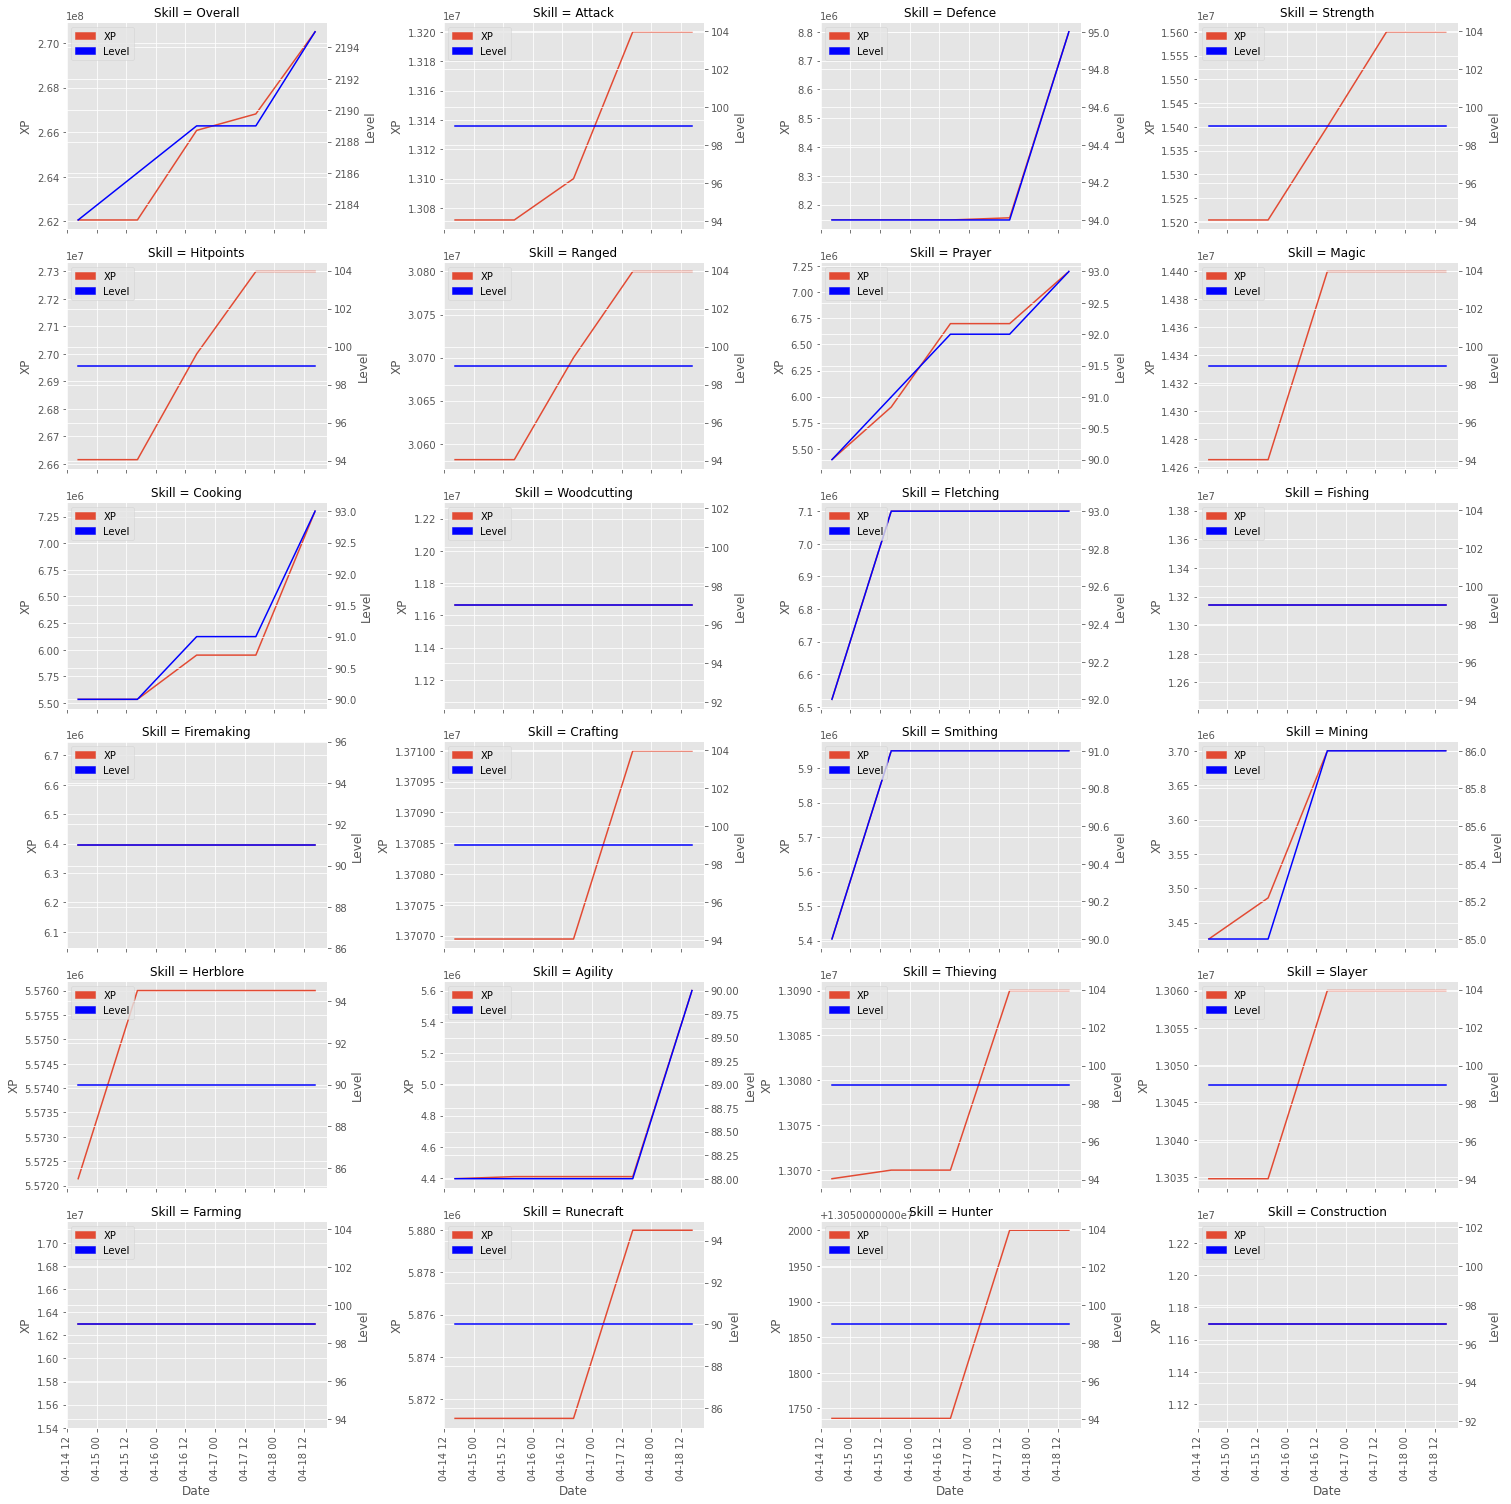

In [26]:
plotting.grid_plots.plot_skills(player)
plt.savefig('seaborn_facetgrid_skills.png')

---

### Plot each boss kill count on figure in facetgrid

C:\Users\emily\Documents\Tom\Coding\OSRS_hiscores\example_plots\..\plotting\grid_plots.py:26: UserWarning:

FixedFormatter should only be used together with FixedLocator



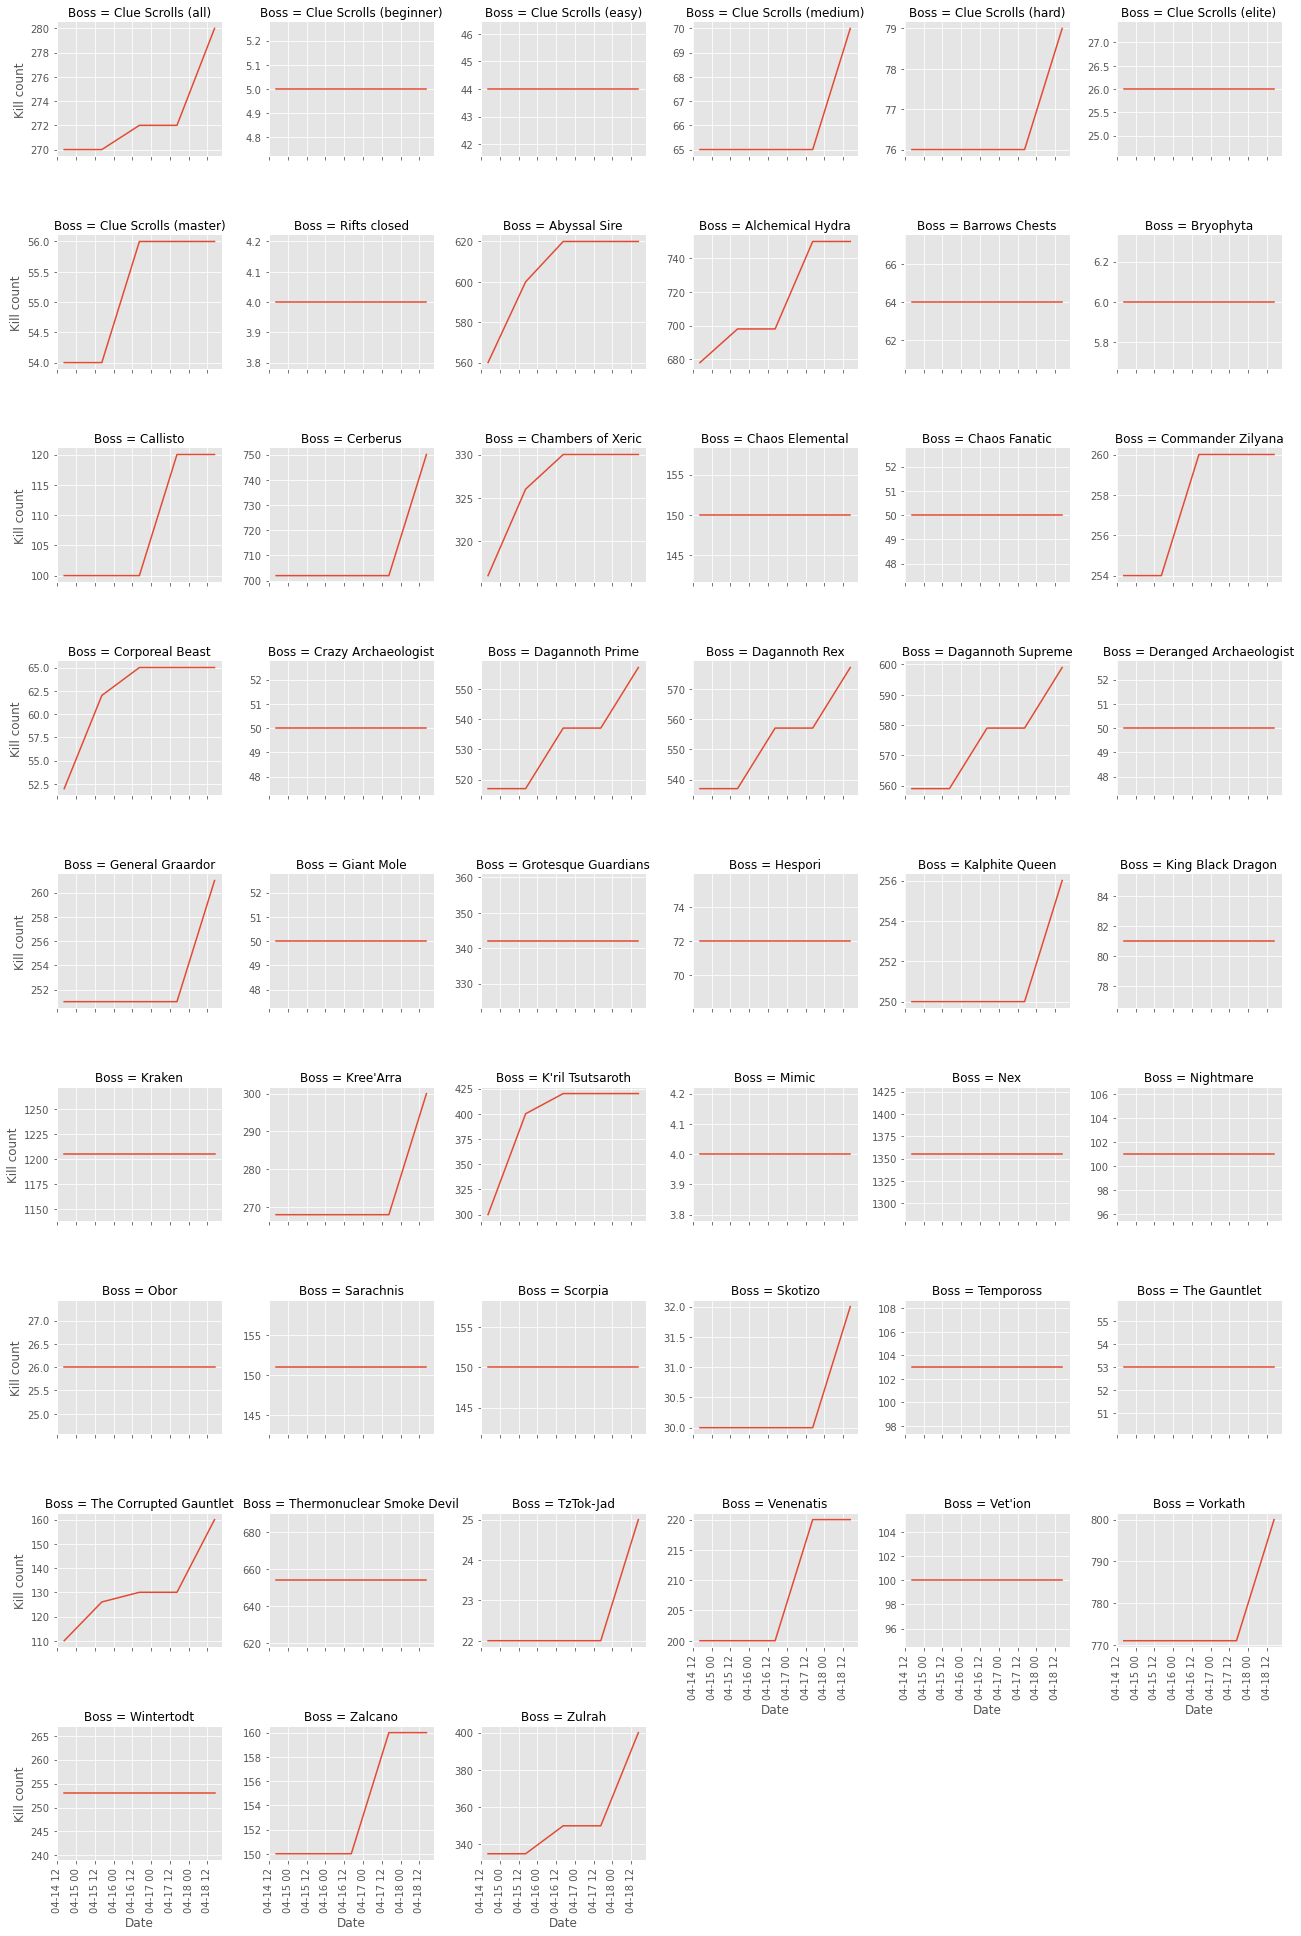

In [27]:
plotting.grid_plots.plot_killcount(player)
plt.savefig('seaborn_facetgrid_killcount.png')